# Learning the Sine Function

For this task, we implement a Quantum Machine Learning (QML) model to learn the $\sin(x)$ function on the interval $x\in[0, 2\pi]$. Classically, To accomplish this one could train a very simple neural network, or perhaps (but less efficiently) use a polynomial regression model that works well in the specified interval. For a QML model, one of the simplest and most efficient choices for a model would be a Quantum Neural Network, which in our case is just a simple variational algorithm.

## The model

As usual, the implementation is split into data encoding $\rightarrow$ variational evolution $\rightarrow$ measurement $\rightarrow$ optimizaztion

### Data Encoding

the input data for probelm are angles $\theta \in [0, 2\pi]$. So, the Angle Embedding method lends itself most naturally. We can do that by applying $RX(\theta)$ to the default qubit state $\ket 0$, but a better incoding is to apply both $RX(\theta)$ and $RY(\theta)$, since this gives a fuller exploration of the state space on the bloch sphere. Our encoding strategy is thus:
$$\theta \in [0, 2\pi] \longmapsto \ket{\psi_{\theta}} = RY(\theta) RX(\theta)\ket 0$$

### The variational ansatz

Since we are using only one qubit for our circuit, the most general ansatze for our variational circuit would be the most general 1-qubit unitary operator, which has 3 degrees of freedom (parameters):
$$ U(\omega, \theta, \phi) = 
\begin{pmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{-i(\phi-\omega)/2}\sin(\theta/2) \\
e^{i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2) 
\end{pmatrix}
= RZ(\omega)RY(\theta)RZ(\phi)
$$

### Measurement

We need to do a measurement on the final state of our qubit after the application of $U(\omega, \theta, \phi)$ such that the measurement's result represents the model's output, which ofcourse needs to be real.

A Hermitian operator $H$ on our Hilbert space $\mathcal{H}$ has only real eigenvalues and thus $\braket{\psi|H|\psi} \in \mathbb{R} \; \forall \psi \in \mathcal{H}$. A good choice for our measurement process is thus to measure the expectation value of the Pauli Z operator, for instance, since it is hermitian and depends smoothly on the state $\ket{\psi_x} $'s coefficients: 
$$ \ket{\psi_x} = \begin{pmatrix} x_0 \\ x_1  \end{pmatrix} \rightarrow \braket{\psi_x|Z|\psi_x} = \begin{pmatrix} x_0^* & x_1^*  \end{pmatrix} \begin{pmatrix} 1 & 0 \\ 0 & -1  \end{pmatrix}  \begin{pmatrix} x_0 \\ x_1  \end{pmatrix} = |x_0|^2 - |x_1|^2$$
Ofcourse, $\braket X$ or $\braket Y$ can work well too.

Our final circuit looks like this:

<div style="text-align:center">
    <img src="img/circuit.png" alt="Alt Text" style="width:900px;"/>
</div>


## Implementation

We first import the necessary packages

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

and define our data encoding method as described above

In [2]:
def prepare_state(x):
    qml.RX(x, wires=0)
    qml.RY(x, wires=0)

define our variational form as our state preparation + ansatz

In [3]:
dev = qml.device("default.qubit", 1)

@qml.qnode(dev)
def variational_form(weights, x):
    prepare_state(x)
    
    qml.Barrier()
    qml.RZ(weights[0], 0)
    qml.RY(weights[1], 0)
    qml.RZ(weights[2], 0)
    qml.Barrier()

    return qml.expval(qml.PauliZ(0))

define our loss fucntion (mean euclidean norm) and cost function (loss + any classical processing)

In [4]:
def loss_func(predictions, targets):
  total_loss = []
  for i in range(len(targets)):

    label = targets[i]
    prediction = predictions[i]
    loss = (prediction - label)**2
    total_loss.append(loss)
    
  return np.mean(np.array(total_loss))

def cost(weights, inputs, lables):
    y_batch = np.array([variational_form(weights, input) for input in inputs])
    return loss_func(y_batch, lables)

Our training data points are $(x, \sin x)$ pairs for $x \in [0, 2\pi]$ the smallest number of data points out model needs for very good approximations of $\sin(x)$ is 7. 

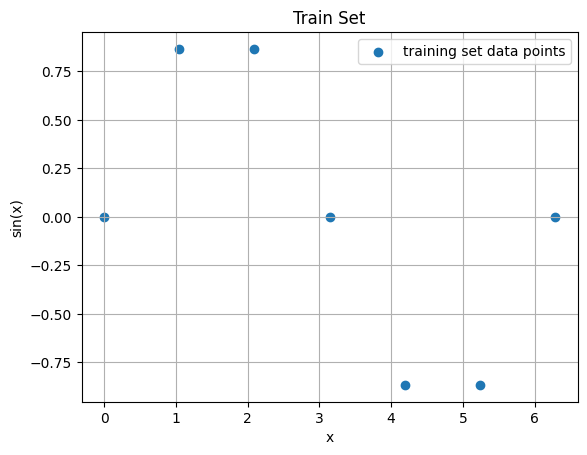

In [5]:
np.random.seed(42)

train_size = 7
X_train = np.linspace(0, 2 * np.pi, train_size)
Y_train = np.sin(X_train)   

# Plotting train set 
plt.scatter(X_train, Y_train,
            label="training set data points")
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Train Set')
plt.legend()
plt.grid(True)
plt.show()

Next we define an optimizer to update the weights $(\omega, \theta, \phi)$, through gradient descent, such that the cost function is minimized and thus 
$$\braket{\psi_{x}|U^{\dagger}(\omega^*, \theta^*, \phi^*)\, Z \, U(\omega^*, \theta^*, \phi^*)|\psi_{x}} \approx \sin(x)$$ 
where $(\omega^*, \theta^*, \phi^*)$ are the optimal parameters.

In [6]:
opt = qml.GradientDescentOptimizer(stepsize=0.5) # Basic gradient-descent optimizer

Now we initialize the weights to random angles in $[0, 2\pi]$, and begin the optimization process of iteratively evaluating the cost fucntion and incrementing the weights opposite to its gradient direction until a minima is reached

In [7]:
weights = np.random.uniform(0, 2*np.pi, 3, requires_grad=True) # Initializing wights with random entries
steps = 40 

cost_hist = []
for step in range(steps):

    weights, current_cost = opt.step_and_cost(cost, weights, inputs=X_train, lables=Y_train)
    cost_hist.append(current_cost)

    if (step+1)%10 == 0 : print(f"Step: {step+1:3d} | Cost: {current_cost:0.6f}") 

Step:  10 | Cost: 0.005395
Step:  20 | Cost: 0.000507
Step:  30 | Cost: 0.000052
Step:  40 | Cost: 0.000005


We can see that the optimization process converges very quickly:

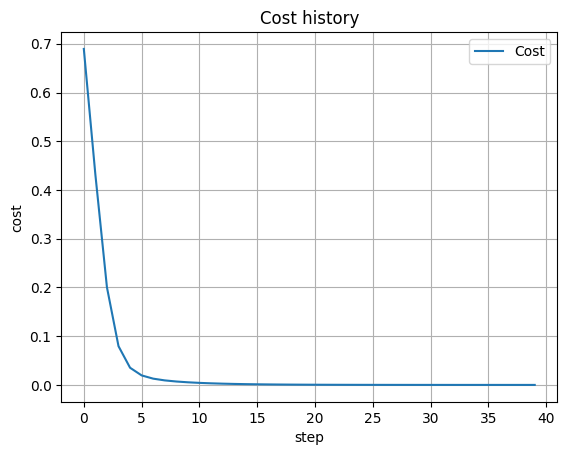

In [8]:
#plotting cost vs iteration
plt.plot(range(steps), cost_hist,label='Cost')

plt.xlabel('step')
plt.ylabel('cost')
plt.title("Cost history")
plt.legend()
plt.grid(True)

plt.show()

To test how well our model generalizes from just the 7 data points it learned, we plot its prediction of $\sin(x)$ Vs $x$ as well as the true $\sin(x)$

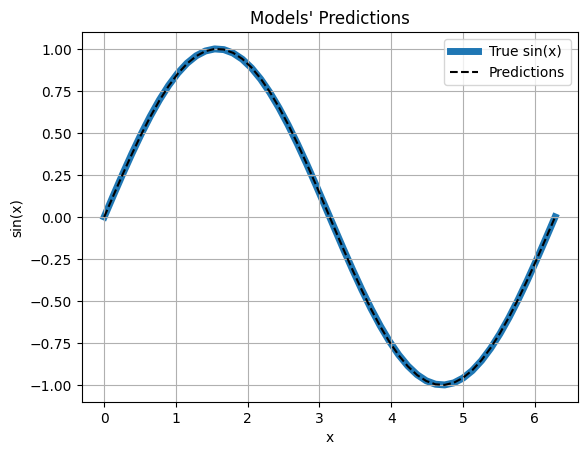

In [9]:
X = np.linspace(0, 2 * np.pi, 50)

predictions = [variational_form(weights, x) for x in X]  

# Create the plots
plt.plot(X, np.sin(X), label='True sin(x)', linewidth=5, zorder=1)
plt.plot(X, predictions, linestyle='--', color='k', label='Predictions', zorder=2)

# Add labels, title, and legend
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title("Models' Predictions")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

As we can see, the model learned our function with great accuracy.